**Clasificador de imágenes para lenguaje de señas colombiano**



In [0]:
!pip install keras
!pip install -q kaggle

**Keras y Kaggle**

Keras es una libreria de Deep Learning para Python cuya premisa es lograr una API muy sencilla y fácil de utilizar. Adicionalmente descargaremos el *dataset* directmanete desde Kaggle.

In [1]:
# Colab Libraries
from google.colab import files
import os, os.path

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random as rd

%matplotlib inline

Using TensorFlow backend.


In [2]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d evernext10/hand-gesture-of-the-colombian-sign-language

100% 21.9G/21.9G [07:58<00:00, 61.8MB/s]
100% 21.9G/21.9G [07:58<00:00, 49.1MB/s]


In [0]:
!mv kaggle.json /root/.kaggle/

Una vez descargado el dataset, lo descomprimimos con el comando `unzip` en la carpeta `data`.




In [0]:
!unzip -uq "hand-gesture-of-the-colombian-sign-language.zip" -d "data"

In [7]:
!ls data/dataset/dataset

desktop.ini  men  Woman


**Depuración**

Algunas imágenes en el dataset presentan conflictos o se encuentran corrompidas. Accedemos al *file system* del notebook para borrarlas con comandos de Unix.

In [0]:
!find . -name \*.ini -type f -delete
!find . -name \*[Conflicto].JPG -type f -delete

!find . -name \*"2_men (107).JPG" -type f -delete
!find . -name \*"2_men (108).JPG" -type f -delete
!find . -name \*"3_men (140).JPG" -type f -delete
!find . -name \*"3_men (141).JPG" -type f -delete
!find . -name \*"4_men (5).JPG" -type f -delete
!find . -name \*"4_men (6).JPG" -type f -delete
!find . -name \*"5_men (177).JPG" -type f -delete
!find . -name \*"6_men (175).JPG" -type f -delete
!find . -name \*"7_woman (127).JPG" -type f -delete

**Preprocesamiento**

La siguiente pieza de código es la encargada de realizar el procesamiento de imágenes y la adaptación de los datos para la red neuronal. La rutina `preprocess_image` es la encargada del escalamaiento y normalización de las imágenes. Adicionalmente, con cada imágen preprocesada, iremos actualizando la lista `img_sign` de etiquetas que almacenará el signo que representa cada seña.

In [9]:
#train = pd.read_csv('multilabel_train_images.csv')

img_path_women = 'data/dataset/dataset/Woman/'
img_path_men = 'data/dataset/dataset/men/'
signs = ['0','1','2','3','4','5','a','e','i','o','u']

img_train = []
img_sign = []
test_size = 0.15
img_size = 100

def preprocess_image(img_filename):
  img = image.load_img(filename, target_size=(img_size, img_size), color_mode='grayscale')
  img = image.img_to_array(img)
  img = img/255
  return img

for i in range(len(signs)):
  dir_women_sign = img_path_women + signs[i].upper() + '/'
  dir_men_sign = img_path_men + signs[i].upper() + '/'

  len_dir_women_sign = len([name for name in os.listdir(dir_women_sign) if os.path.isfile(os.path.join(dir_women_sign, name))])
  len_dir_men_sign = len([name for name in os.listdir(dir_men_sign) if os.path.isfile(os.path.join(dir_men_sign, name))])

  #train_indexes_w, test_indexes_w = split_by_percent(range(len_dir_women_sign), test_size)
  #train_indexes_m, test_indexes_m = split_by_percent(range(len_dir_men_sign), test_size)

  print('size(%s) = %s' % (dir_women_sign, len_dir_women_sign))
  print('size(%s) = %s' % (dir_men_sign, len_dir_men_sign))

  row_count = 0

  print('importing ' + signs[i])

  for j in range(len_dir_women_sign):
    row_count = 0
    try:
      filename = dir_women_sign + signs[i] + '_woman (' + str(j+1) + ').JPG'
      #print(' loading image ' + filename)
      img_train.append(preprocess_image(filename))
      img_sign.append(i)
      row_count += 1
    except:
      print('Some files did not load...')

  print('row_count (train): ' + str(row_count))
    
  for j in range(len_dir_men_sign):
    row_count = 0
    try:
      filename = dir_men_sign + signs[i] + '_men (' + str(j+1) + ').JPG'
      #print(' loading image ' + filename)
      img_train.append(preprocess_image(filename))
      img_sign.append(i)
      row_count += 1
    except:
      print('Some files did not load...')
  
  print('row_count (train): ' + str(row_count))

x = np.array(img_train)
y = np.array(img_sign)

print('*Carga terminada*')


size(data/dataset/dataset/Woman/0/) = 115
size(data/dataset/dataset/men/0/) = 172
importing 0
row_count (train): 1
row_count (train): 1
size(data/dataset/dataset/Woman/1/) = 125
size(data/dataset/dataset/men/1/) = 175
importing 1
row_count (train): 1
row_count (train): 1
size(data/dataset/dataset/Woman/2/) = 133
size(data/dataset/dataset/men/2/) = 175
importing 2
row_count (train): 1
Some files did not load...
Some files did not load...
row_count (train): 1
size(data/dataset/dataset/Woman/3/) = 136
size(data/dataset/dataset/men/3/) = 180
importing 3
row_count (train): 1
Some files did not load...
Some files did not load...
row_count (train): 1
size(data/dataset/dataset/Woman/4/) = 133
size(data/dataset/dataset/men/4/) = 168
importing 4
row_count (train): 1
Some files did not load...
Some files did not load...
Some files did not load...
Some files did not load...
Some files did not load...
Some files did not load...
row_count (train): 1
size(data/dataset/dataset/Woman/5/) = 132
size(dat

Visualizamos alguna de las imágenes para verificar que la carga ha sido correcta y que la imágen corresponda con la etqueta.

(100, 100)


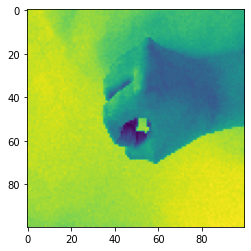

9


In [10]:
# Visualize some loaded signs
index = 3000
x_train2d = x[index][:,:,0]
print(x_train2d.shape)
plt.imshow(x_train2d)
plt.show()

print(y[index])

Finalmente, determinamos los conjuntos de entrenamiento y prueba, y codificamos las variables categoricas para la red neuronal.

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

y_train_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [12]:
# Model 2
# Create the architecture
model2 = Sequential()
# Covolutional layer
model2.add(Conv2D(255, (5,5), activation = 'relu', input_shape=(img_size,img_size,1)))
# MaxPooling layer
model2.add( MaxPooling2D(pool_size = (2,2) ))
# Covolutional layer
model2.add(Conv2D(255, (5,5), activation = 'relu'))
# MaxPooling layer
model2.add( MaxPooling2D(pool_size = (2,2) ))
# Flatten layer
model2.add(Flatten())
model2.add(Dense(1000, activation='relu'))
model2.add(Dense(11, activation ='softmax'))


model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model2.fit(x_train, y_train_one_hot, epochs=10, validation_data=(x_test, y_test_one_hot), batch_size=256, callbacks=[history])

Train on 2644 samples, validate on 662 samples
Epoch 1/10
2644/2644 [==============================] - 1103s 417ms/step - loss: 0.6772 - accuracy: 0.8944 - val_loss: 0.3060 - val_accuracy: 0.9091
Epoch 2/10
2644/2644 [==============================] - 1092s 413ms/step - loss: 0.3050 - accuracy: 0.9091 - val_loss: 0.3046 - val_accuracy: 0.9091
Epoch 3/10
2644/2644 [==============================] - 1091s 413ms/step - loss: 0.3046 - accuracy: 0.9091 - val_loss: 0.3047 - val_accuracy: 0.9091
Epoch 4/10
2644/2644 [==============================] - 1096s 414ms/step - loss: 0.3046 - accuracy: 0.9091 - val_loss: 0.3063 - val_accuracy: 0.9091
Epoch 5/10
2644/2644 [==============================] - 1093s 413ms/step - loss: 0.3024 - accuracy: 0.9091 - val_loss: 0.2990 - val_accuracy: 0.9091
Epoch 6/10
2644/2644 [==============================] - 1089s 412ms/step - loss: 0.2896 - accuracy: 0.9091 - val_loss: 0.2862 - val_accuracy: 0.9099
Epoch 7/10
2644/2644 [==============================] - 109

En la siguiente celda podemos ver un resumen de la arquitectura utilizada

In [13]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 255)       6630      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 255)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 255)       1625880   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 255)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 123420)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              123421000 
_________________________________________________________________
dense_2 (Dense)              (None, 11)               

Evaluamos el modelo para conecer su precisión.

In [14]:
model2.evaluate(x_test, y_test_one_hot)[1]

662/662 [==============================] - 75s 113ms/step


0.9138972759246826

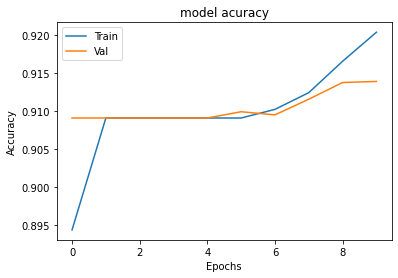

In [15]:
# Visualize the accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model acuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Val'], loc='upper left')

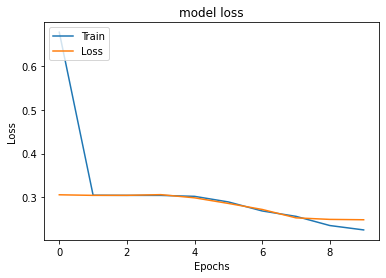

In [16]:
# Visualize the data loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend(['Train', 'Loss'], loc='upper left')

In [54]:
uploaded = files.upload()
my_img = plt.imread('example2.jpg')


Saving example2.jpg to example2.jpg


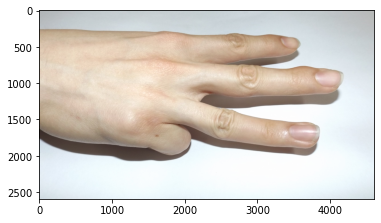

In [55]:
plt.imshow(my_img)

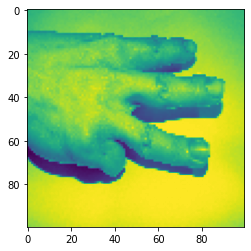

In [57]:
test_img = image.load_img('example2.jpg', target_size=(img_size, img_size), color_mode='grayscale')
plt.imshow(test_img)
test_img = image.img_to_array(test_img)
test_img = test_img/255

test_img = np.array(test_img)



In [58]:
probs = model2.predict( np.array( [test_img,] ) )
print(probs)
last = 10
index = np.argsort(probs[0,:])
print('Clase más probable:', signs[index[last]], '--probability:', probs[0, index[last]])

[[0.10751827 0.3273913  0.16890346 0.05509826 0.07911997 0.01432617
  0.00311089 0.02390408 0.12622662 0.04376962 0.05063136]]
Clase más probable: 1 --probability: 0.3273913
